to run if you work on google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If you didn't download the dataset yet, you can run this cell to do it and load the dataset into your google drive.

In [ ]:
!pip install gdown
# id of the pubblic zipped dataset in google drive
!gdown --id 1a-CUf1Zy5kj-c7gcNMf2KISq855c1s9D

#Libraries

In [ ]:
!nvidia-smi

Sat Jan 13 17:41:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              33W /  70W |  14079MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install tensorflow-addons
!pip install vit_keras

In [ ]:
import os
import cv2
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.morphology import label
from skimage.io import imread, imshow, imread_collection, concatenate_images
import tensorflow as tf
from vit_keras import utils
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import (
    Dense, Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate,
    Activation, Add, multiply, add, concatenate, LeakyReLU, ZeroPadding2D, UpSampling2D,
    BatchNormalization, SeparableConv2D, Flatten, GlobalAveragePooling2D )

# Statistics

Function which gives a dictionary with formats and images total number for each folder in the path.


In [ ]:
def image_dataset_format_statistics(base_path):
    # Dictionary to hold statistics
    stats = {}

    # Iterate through each folder in the base path
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            # Dictionary to count image formats
            format_count = {}

            # Iterate through each file in the folder
            for file in os.listdir(folder_path):
                if os.path.isfile(os.path.join(folder_path, file)):
                    extension = os.path.splitext(file)[1].lower()  # Get file extension
                    format_count[extension] = format_count.get(extension, 0) + 1

            # Update stats for the folder
            stats[folder] = {
                'total_images': sum(format_count.values()),
                'format_count': format_count
            }

    return stats

# Usage example
base_path = '/content/drive/MyDrive/dataset_pulito/chest_xray'  # Replace with the dataset path
statistics = image_dataset_format_statistics(base_path)
print(statistics)

{'abscess': {'total_images': 9, 'format_count': {'.jpg': 9}}, 'atelectasis': {'total_images': 7, 'format_count': {'.jpg': 7}}, 'ards': {'total_images': 2, 'format_count': {'.jpg': 2}}, 'atherosclerosis_of_the_aorta': {'total_images': 6, 'format_count': {'.jpg': 6}}, 'cardiomegaly': {'total_images': 8, 'format_count': {'.jpg': 8}}, 'emphysema': {'total_images': 5, 'format_count': {'.jpg': 5}}, 'fracture': {'total_images': 6, 'format_count': {'.jpg': 6}}, 'hydropneumothorax': {'total_images': 9, 'format_count': {'.jpg': 9}}, 'hydrothorax': {'total_images': 5, 'format_count': {'.jpg': 5}}, 'Normal': {'total_images': 4885, 'format_count': {'.jpg': 4885}}, 'Pneumonia': {'total_images': 3456, 'format_count': {'.jpg': 3456}}, 'pneumosclerosis': {'total_images': 4, 'format_count': {'.jpg': 4}}, 'post_inflammatory_changes': {'total_images': 7, 'format_count': {'.jpg': 7}}, 'post_traumatic_ribs_deformation': {'total_images': 5, 'format_count': {'.jpg': 5}}, 'scoliosis': {'total_images': 4, 'form

#Data cleaning




Prior to the cleaning process, the images underwent a series of pre-processing measures aimed at eliminating elements that could potentially introduce noise during the model training phase. This refinement was accomplished through the application of several scripts, each tailored to address specific types of unwanted features:

    
*   black_border.py was employed to remove any black borders that might skew the model's focus.

*   white_border.py targeted the eradication of white borders for a similar purpose.


*    white_boxes.py addressed the presence of white boxes, which were filled or blended into the background to prevent the model from learning irrelevant patterns.





    
   

Following the removal of these features, the images were systematically renamed in a sequential order using rename_images.py, ensuring a uniform and organized dataset ready for the subsequent stages of model training.

the cleaning tecnique used were:

1.   **Convert to RGB**: Each image is converted to a three-channel RGB format. This step ensures color channel consistency across all images.
2.   **Resize (Enlarge/Shrink)**: Images are resized in such a way that the aspect ratio is maintained. The resizing process ensures that the smallest dimension (width or height) matches or exceeds the corresponding dimension of the target size (224x224). This step is crucial for maintaining the original aspect ratio of the image while ensuring complete coverage for cropping.
3.**Crop to 224x224**: Post resizing, the images are cropped to a fixed size of 224x224 pixels, focusing on the center. This cropping is done to standardize the size of all images in the dataset and to address the requirements of tenserflow models.



    

    



In [ ]:
from PIL import Image

def convert_to_rgb(img):
    return Image.merge("RGB", (img, img, img))

def enlarge_and_crop_center(img, target_size):
    # calculate the enlarge factor
    width_scale = target_size[0] / img.width
    height_scale = target_size[1] / img.height
    scale_factor = max(width_scale, height_scale)

    # enlargment and crop in the middle to focus on lungs feature
    new_size = (int(img.width * scale_factor), int(img.height * scale_factor))
    img_enlarged = img.resize(new_size, Image.Resampling.LANCZOS)
    left = (img_enlarged.width - target_size[0]) / 2
    top = (img_enlarged.height - target_size[1]) / 2
    right = (img_enlarged.width + target_size[0]) / 2
    bottom = (img_enlarged.height + target_size[1]) / 2
    img_cropped = img_enlarged.crop((left, top, right, bottom))
    img_array = np.array(img_cropped)
    return Image.fromarray(img_array)

def process_images(source_folder, dest_folder, image_size=(224, 224)):
    for class_folder in os.listdir(source_folder):
        source_class_folder_path = os.path.join(source_folder, class_folder)
        dest_class_folder_path = os.path.join(dest_folder, class_folder)

        if os.path.isdir(source_class_folder_path):
            if not os.path.exists(dest_class_folder_path):
                os.makedirs(dest_class_folder_path)

            for img_file in os.listdir(source_class_folder_path):
                source_img_path = os.path.join(source_class_folder_path, img_file)
                dest_img_path = os.path.join(dest_class_folder_path, os.path.splitext(img_file)[0] + '.jpg')

                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.isfile(source_img_path):
                    img = Image.open(source_img_path).convert('L')
                    img_rgb = convert_to_rgb(img)
                    img_processed = enlarge_and_crop_center(img_rgb, image_size)
                    img_processed.save(dest_img_path, 'JPEG')

In [ ]:
source_folder = '/content/drive/MyDrive/dataset_pulito/chest_xray'  # Replace with dataset path
processed_folder = '/content/drive/MyDrive/dataset_pulito/clean_data'  # This folder will contain the resized images


# If you want to overwrite the images in the same directory, you can pass `dest_folder=None`
process_images(source_folder, processed_folder)

# Check the cleaning


The function below aims to check the dimension of the dataset images, to understand if they are fitted for training.

In [ ]:
def check_image_dimensions(folder_path, target_size=(224, 224)):
    matching_format_count = 0
    non_matching_format_count = 0

    for subdir, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(subdir, file)
                with Image.open(img_path) as img:
                    if img.size == target_size:
                        matching_format_count += 1
                    else:
                        non_matching_format_count += 1

    return matching_format_count, non_matching_format_count

In [ ]:
# Specify the folder path where the images are stored
folder_path = '/content/drive/MyDrive/dataset_pulito/augmented_class'  # Replace with the your path if different

# Check image dimensions
matching, non_matching = check_image_dimensions(folder_path)
print(f"Images in format {224}x{224}: {matching}")
print(f"Images not in format {224}x{224}: {non_matching}")

Images in format 224x224: 1740
Images not in format 224x224: 0


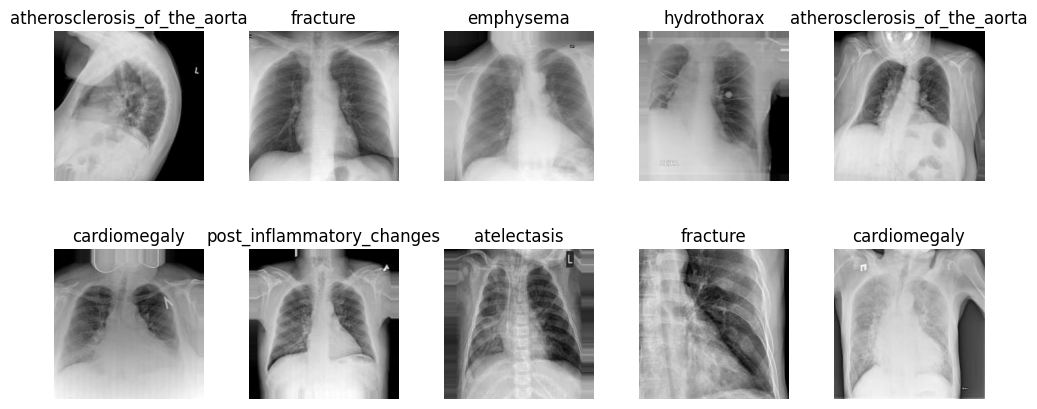

In [ ]:
def display_random_images(folder_path, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    class_folders = os.listdir(folder_path)
    for ax in axes.flatten():
        class_folder = random.choice(class_folders)
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            image_files = [file for file in os.listdir(class_path) if file.lower().endswith('.jpg')]
            if image_files:
                image_file = random.choice(image_files)
                img_path = os.path.join(class_path, image_file)

                img = plt.imread(img_path)
                ax.imshow(img)
                ax.set_title(class_folder)
                ax.axis('off')

    plt.show()


augmented_data_path = '/content/drive/MyDrive/dataset_pulito/augmented_class' # Change with the path of the augmeted class folder
display_random_images(augmented_data_path)

# Data Augmentation

    
1.   Rotation: Rotating images from 1 to 15 degrees.

2.   Horizontal Flip: This creates 1 additional image per original image, no more than one to not have duplicates.
3.   Zoom: Assuming one level of zoom.

4.   Contrast Adjustment: Using brightness variation to simulate contrast changes.

5. Elastic Deformation Simulation: using shear and shifts to simulate wrong position or movement of the patient.

Given these techniques, every image is one simple trasformation for factor of augmentation.

For further experimentation, it was also implemented a function which mix all the trasformation together.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

def rotate_image(img_array):
    datagen = ImageDataGenerator(rotation_range=15)
    return next(datagen.flow(img_array, batch_size=1))

def elastic_deformation(img_array):
    datagen = ImageDataGenerator(
        width_shift_range=0.1,  # Horizontal shift
        height_shift_range=0.1,  # Vertical shift
        shear_range=5.0  # Shear transformation
    )
    return next(datagen.flow(img_array, batch_size=1))

def zoom_image(img_array):
    datagen = ImageDataGenerator(zoom_range=0.2)
    return next(datagen.flow(img_array, batch_size=1))

def flip_image(img_array):
    datagen = ImageDataGenerator(horizontal_flip=True)
    return next(datagen.flow(img_array, batch_size=1))

def adjust_brightness(img_array):
    datagen = ImageDataGenerator(brightness_range=[0.8, 1.2])
    return next(datagen.flow(img_array, batch_size=1))


In [ ]:
def simple_augment_small_classes(source_folder, augmented_folder, min_images=10, augment_factor=20):
    augmentation_functions = [rotate_image, flip_image, elastic_deformation, zoom_image, adjust_brightness]  # Add all your defined functions here

    for class_folder in os.listdir(source_folder):
        class_folder_path = os.path.join(source_folder, class_folder)

        if os.path.isdir(class_folder_path) and len(os.listdir(class_folder_path)) < min_images:
            augmented_class_folder_path = os.path.join(augmented_folder, class_folder)
            if not os.path.exists(augmented_class_folder_path):
                os.makedirs(augmented_class_folder_path)

            for img_file in os.listdir(class_folder_path):
                img_path = os.path.join(class_folder_path, img_file)
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = img_array.reshape((1,) + img_array.shape)

                for i in range(augment_factor):
                    # Apply a random augmentation or a combination
                    func = random.choice(augmentation_functions)
                    augmented_img_array = func(img_array)

                    # For simpler augmentations, add an additional random augmentation
                    if func in [flip_image]:  # Add other simple functions if needed
                        additional_func = random.choice([f for f in augmentation_functions if f != func])
                        augmented_img_array = additional_func(augmented_img_array)

                    # Convert back to image and save
                    augmented_img = image.array_to_img(augmented_img_array[0])
                    augmented_img_file = f'aug_{img_file[:-4]}_{i}.jpg'
                    augmented_img.save(os.path.join(augmented_class_folder_path, augmented_img_file))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

def augment_small_classes_all_combination(source_folder, augmented_folder, min_images=10, augment_factor=19):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=5.0,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    for class_folder in os.listdir(source_folder):
        class_folder_path = os.path.join(source_folder, class_folder)

        if os.path.isdir(class_folder_path) and len(os.listdir(class_folder_path)) < min_images:
            augmented_class_folder_path = os.path.join(augmented_folder, class_folder)

            if not os.path.exists(augmented_class_folder_path):
                os.makedirs(augmented_class_folder_path)

            for img_file in os.listdir(class_folder_path):
                img_path = os.path.join(class_folder_path, img_file)
                img = image.load_img(img_path, target_size=(224, 224))
                img = image.img_to_array(img)
                img = img.reshape((1,) + img.shape)

                i = 0
                for batch in datagen.flow(img, batch_size=1,
                                          save_to_dir=augmented_class_folder_path,
                                          save_prefix='aug_' + img_file[:-4],
                                          save_format='jpg'):
                    i += 1
                    if i >= augment_factor:
                        break


In [ ]:
source_folder = '/content/drive/MyDrive/dataset_pulito/clean_data'  # Adjust the path if need it
augmented_folder = '/content/drive/MyDrive/dataset_pulito/augmented_class'  # Adjust the path if neccesary

simple_augment_small_classes(source_folder, augmented_folder)

# Create train, val, test

In [ ]:
def list_images_and_labels(base_path):
    images = []
    labels = []
    for class_folder in os.listdir(base_path):
        class_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith('.jpg'):
                    images.append(os.path.join(class_path, img_file))
                    labels.append(class_folder)
    return images, labels

The function below targets the imbalance of the dataset, using two methods:


1.   **Oversample small calles:** it oversamples the small classes, identified thanks to the treshold.
2.   **Undersample big classes:**it undersamples slightly the big classes.



In [ ]:
from collections import Counter

def balance_classes(images, labels, small_class_threshold=300, large_class_threshold=1000):
    count = Counter(labels)
    balanced_images = []
    balanced_labels = []

    for img, label in zip(images, labels):
        # Oversampling for smaller classes
        if count[label] < small_class_threshold:
            multiplier = small_class_threshold // count[label] + 1
            balanced_images.extend([img] * multiplier)
            balanced_labels.extend([label] * multiplier)

        # Light undersampling for larger classes
        elif count[label] > large_class_threshold:
            if random.random() < 0.7:  # Adjust the sampling rate as needed
                balanced_images.append(img)
                balanced_labels.append(label)

        # No sampling for middle-sized classes
        else:
            balanced_images.append(img)
            balanced_labels.append(label)

    return balanced_images, balanced_labels


In [ ]:
from sklearn.model_selection import train_test_split

def split_dataset(images, labels, test_size=0.2, val_size=0.2):
    # Split images and labels together
    train_val_images, test_images, train_val_labels, test_labels = train_test_split(images, labels, test_size=test_size)
    train_images, val_images, train_labels, val_labels = train_test_split(train_val_images, train_val_labels, test_size=val_size)
    return train_images, val_images, test_images, train_labels, val_labels, test_labels

In [ ]:
clean_data_path = '/content/drive/MyDrive/dataset_pulito/clean_data'  # Adjust with your path
augmented_data_path = '/content/drive/MyDrive/dataset_pulito/augmented_class' # Adjust with your path

clean_images, clean_labels = list_images_and_labels(clean_data_path)
augmented_images, augmented_labels = list_images_and_labels(augmented_data_path)

all_images = clean_images + augmented_images
all_labels = clean_labels + augmented_labels

balanced_images, balanced_labels = balance_classes(all_images, all_labels)
train_images, val_images, test_images, train_labels, val_labels, test_labels = split_dataset(balanced_images, balanced_labels)

In [ ]:
def print_dataset_sizes(train_images, val_images, test_images):
    print(f"Total number of images in training set: {len(train_images)}")
    print(f"Total number of images in validation set: {len(val_images)}")
    print(f"Total number of images in test set: {len(test_images)}")
    print(f"Total number of images in dataset: {len(train_images) + len(val_images) + len(test_images)}")


print_dataset_sizes(train_images, val_images, test_images)

Total number of images in training set: 7532
Total number of images in validation set: 1884
Total number of images in test set: 2355
Total number of images in dataset: 11771


to address the class imbalance even more, it creates a dictionary with class weights to use during training.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Step 1: Map class names to integer indices and create inverse mapping
unique_classes = set(clean_labels + augmented_labels)  # Get all unique class names
class_to_index = {cls_name: index for index, cls_name in enumerate(unique_classes)}
index_to_class = {index: cls_name for cls_name, index in class_to_index.items()}

# Step 2: Convert labels to indices for train, val, and test sets
train_labels_indices = [class_to_index[label] for label in train_labels]
val_labels_indices = [class_to_index[label] for label in val_labels]
test_labels_indices = [class_to_index[label] for label in test_labels]

# Compute initial class weights using integer indices
initial_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_indices),
    y=train_labels_indices
)

# Convert to a dictionary using integer indices as keys
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(train_labels_indices), initial_class_weights)}

# Manually adjust weights for the larger classes using their integer indices
adjustment_factor = 0.5  # Adjust this factor as needed
for large_class_name in ['Normal', 'Pneumonia', 'Tuberculosis']:
    if large_class_name in class_to_index:
        large_class_index = class_to_index[large_class_name]
        class_weights_dict[large_class_index] *= adjustment_factor

# Output the adjusted class weights
print(class_weights_dict)

{0: 0.5029380341880342, 1: 1.6872759856630823, 2: 1.8764324862979571, 3: 1.92831541218638, 4: 1.4682261208576999, 5: 1.9737945492662474, 6: 0.1397610034884584, 7: 1.714936247723133, 8: 1.8352826510721247, 9: 1.9831490258030542, 10: 1.5271695052716951, 11: 1.7730696798493408, 12: 1.714936247723133, 13: 2.081813156440022, 14: 1.8515240904621435, 15: 0.0972674208378532, 16: 2.134920634920635, 17: 1.8764324862979571}


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0  # Convert to float and normalize
    return img

def create_dataset(image_paths, labels, batch_size=32, shuffle=False):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = path_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
    if shuffle:
        image_label_ds = image_label_ds.shuffle(buffer_size=len(image_paths))
    return image_label_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Convert labels to one-hot encoding
num_classes = len(unique_classes)  # Total number of classes
print("Numero di classi:", num_classes)
train_labels_one_hot = to_categorical(train_labels_indices, num_classes)
val_labels_one_hot = to_categorical(val_labels_indices, num_classes)
test_labels_one_hot = to_categorical(test_labels_indices, num_classes)

# Create datasets with one-hot encoded labels
train_dataset = create_dataset(train_images, train_labels_one_hot, shuffle=True)
val_dataset = create_dataset(val_images, val_labels_one_hot)
test_dataset = create_dataset(test_images, test_labels_one_hot)

Numero di classi: 18


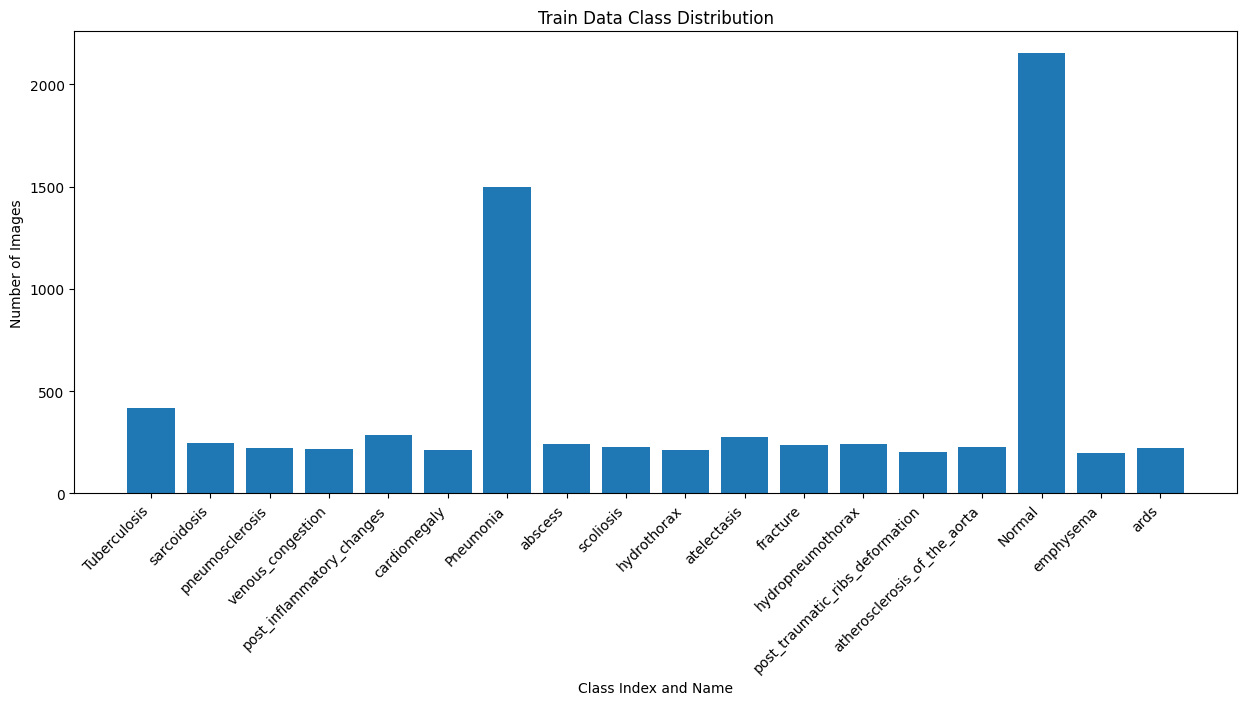

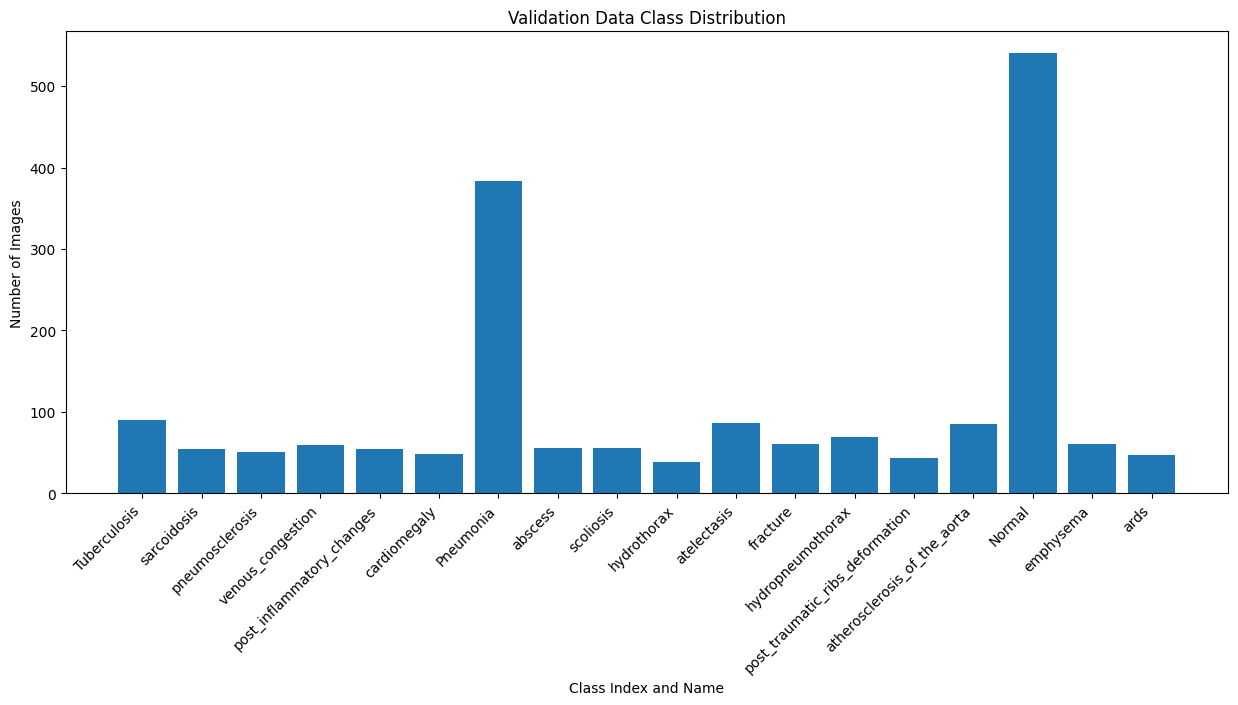

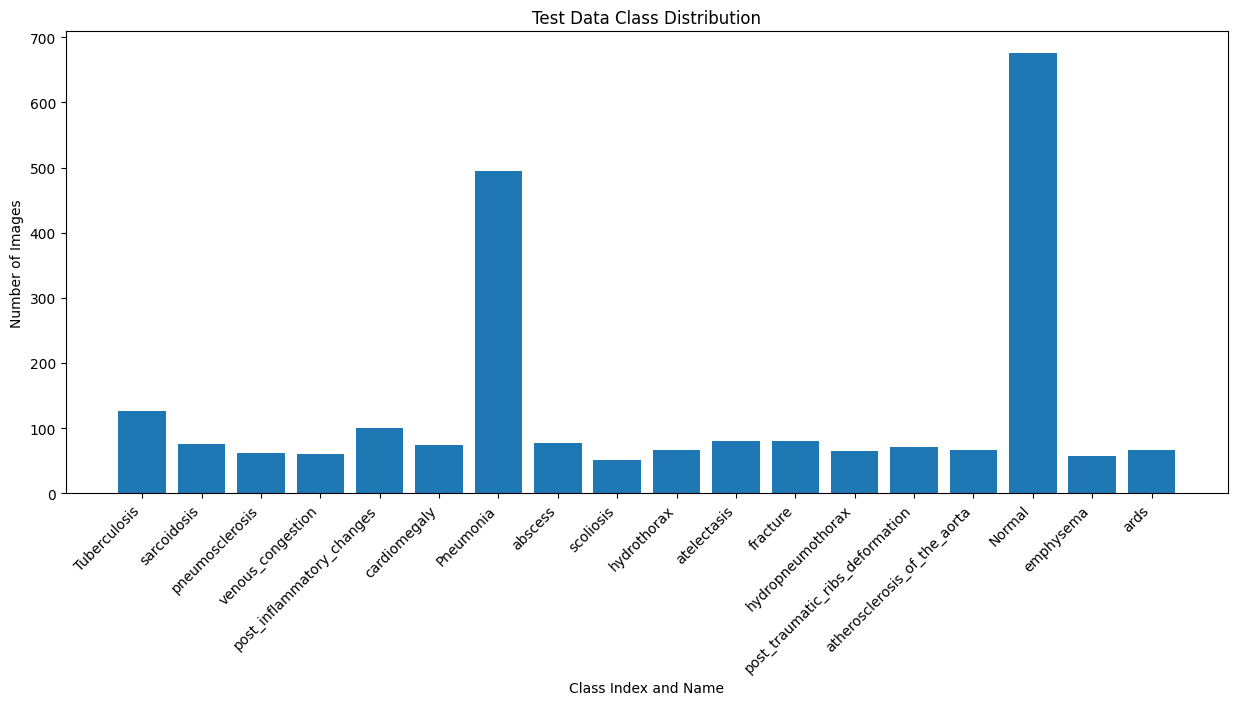

In [ ]:
import matplotlib.pyplot as plt

# Function to plot class distribution with class names and indices
def plot_class_distribution_with_names(labels_indices, class_to_index, title):
    # Count occurrences of each class index in the labels
    class_counts = Counter(labels_indices)

    # Prepare data for plotting
    class_indices = sorted(class_to_index.values())
    class_names = [index_to_class[index] for index in class_indices]
    counts = [class_counts.get(index, 0) for index in class_indices]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(class_indices)), counts, tick_label=class_names)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Class Index and Name')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()

# Plot histograms for train, validation, and test datasets
plot_class_distribution_with_names(train_labels_indices, class_to_index, 'Train Data Class Distribution')
plot_class_distribution_with_names(val_labels_indices, class_to_index, 'Validation Data Class Distribution')
plot_class_distribution_with_names(test_labels_indices, class_to_index, 'Test Data Class Distribution')

#Model implementation

In this section, we implement two convolutional neural network models for the task of image classification. Both models leverage pre-trained architectures: ResNet50 and DenseNet121.

#ResNet50 pretrained model


The ResNet50 model is utilized with pre-loaded ImageNet weights. The top layers of the network are set to be trainable, allowing the model to fine-tune on our specific dataset. This model is augmented with additional dense layers, batch normalization, ReLU activation functions, and dropout layers for regularization.

In [ ]:
from tensorflow.keras.applications import ResNet50

class ResNet50_model(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet50_model, self).__init__()
        self.resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

        for layer in self.resnet50.layers[-10:]:
            layer.trainable = True

        self.global_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(1024)
        self.batch_norm1 = BatchNormalization()
        self.activation1 = Activation('relu')
        self.dropout1 = Dropout(0.5)
        self.dense2 = Dense(1024)
        self.batch_norm2 = BatchNormalization()
        self.activation2 = Activation('relu')
        self.dropout2 = Dropout(0.5)
        self.final_dense = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.resnet50(inputs)
        x = self.global_pool(x)
        x = self.dense1(x)
        x = self.batch_norm1(x, training=training)
        x = self.activation1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.batch_norm2(x, training=training)
        x = self.activation2(x)
        x = self.dropout2(x, training=training)
        return self.final_dense(x)

#DenseNet-121 pretrained model

Similarly, we employ the DenseNet121 architecture with ImageNet weights. In this case, we freeze all the base layers during training to keep the learned features intact and append our own dense layer with a ReLU activation followed by a dropout layer.

In [ ]:
from tensorflow.keras.applications import DenseNet121

class DenseNet121_model(Model):
    def __init__(self, num_classes):
        super(DenseNet121_model, self).__init__()
        self.densenet121 = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

        # Freeze the layers of the base model
        for layer in self.densenet121.layers:
            layer.trainable = False

        # Custom layers
        self.global_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(1024, activation='relu')
        self.dropout = Dropout(0.5)
        self.final_dense = Dense(num_classes, activation='softmax')  # Use 'sigmoid' for binary classification

    def call(self, inputs, training=False):
        x = self.densenet121(inputs)
        x = self.global_pool(x)
        x = self.dense1(x)
        x = self.dropout(x, training=training)
        return self.final_dense(x)

# Instantiate model

In [ ]:
model_Res = ResNet50_model(num_classes)
model_Dense = DenseNet121_model(num_classes)

#Optimizer, loss and metrics



Both models are compiled with the Adam optimizer and categorical crossentropy loss function, suitable for multi-class classification tasks. We also track several performance metrics, including:

1.   accuracy
2.   precision
3.   recall
4.   F1 score

Note: to train the two models is recomended to run the optimizer cell and compling cell before training every training

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

optimizer_res = Adam(learning_rate=0.001)
loss_res = 'categorical_crossentropy'


metrics_res = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall'),
    tf.keras.metrics.F1Score(threshold=0.5, name='f1_score')  # For binary classification
]

In [ ]:
# Compile ResNet50 Model
model_Res.compile(optimizer=optimizer_res, loss=loss_res, metrics=metrics_res)

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Training for ResNet-50

In [ ]:
# Training ResNet-50 model
with tf.device('/device:GPU:0'):
  history_Res = model_Res.fit(
      train_dataset,
      epochs=20,
      validation_data=val_dataset,
      class_weight=class_weights_dict
  )

Epoch 1/20
236/236 [==============================] - 740s 924ms/step - loss: 1.3048 - accuracy: 0.4543 - precision: 0.6414 - recall: 0.3375 - f1_score: 0.4782 - val_loss: 4.1100 - val_accuracy: 0.0228 - val_precision: 0.0228 - val_recall: 0.0228 - val_f1_score: 0.0025
Epoch 2/20
236/236 [==============================] - 97s 368ms/step - loss: 0.4817 - accuracy: 0.7176 - precision: 0.7671 - recall: 0.6665 - f1_score: 0.7594 - val_loss: 13.6931 - val_accuracy: 0.0478 - val_precision: 0.0478 - val_recall: 0.0478 - val_f1_score: 0.0051
Epoch 3/20
236/236 [==============================] - 96s 368ms/step - loss: 0.2197 - accuracy: 0.8230 - precision: 0.8482 - recall: 0.7970 - f1_score: 0.8656 - val_loss: 10.2121 - val_accuracy: 0.2192 - val_precision: 0.2201 - val_recall: 0.2192 - val_f1_score: 0.0311
Epoch 4/20
236/236 [==============================] - 97s 368ms/step - loss: 0.1238 - accuracy: 0.8822 - precision: 0.8952 - recall: 0.8711 - f1_score: 0.9129 - val_loss: 4.8447 - val_accura

loss and accuracy

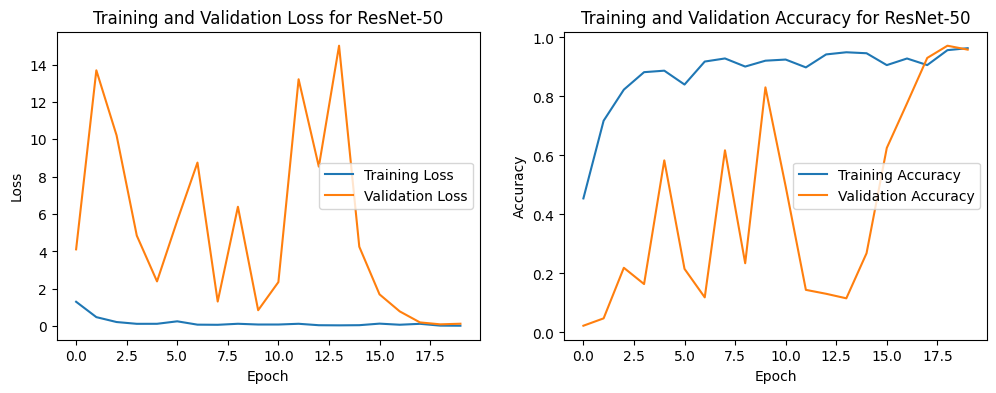

In [ ]:
# Plot Training and Validation Loss and Accuracy for ResNet-50
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_Res.history['loss'], label='Training Loss')
plt.plot(history_Res.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for ResNet-50')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_Res.history['accuracy'], label='Training Accuracy')
plt.plot(history_Res.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for ResNet-50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

precision

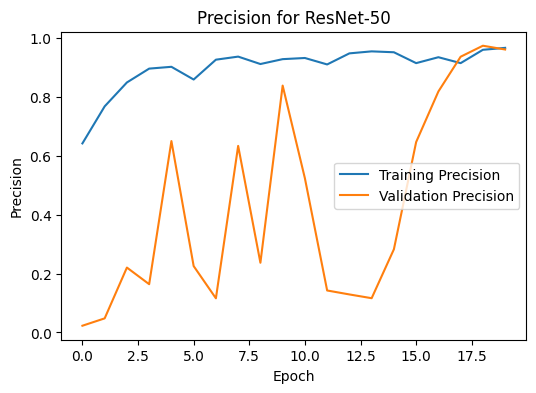

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history_Res.history['precision'], label='Training Precision')
plt.plot(history_Res.history['val_precision'], label='Validation Precision')
plt.title('Precision for ResNet-50')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

recall

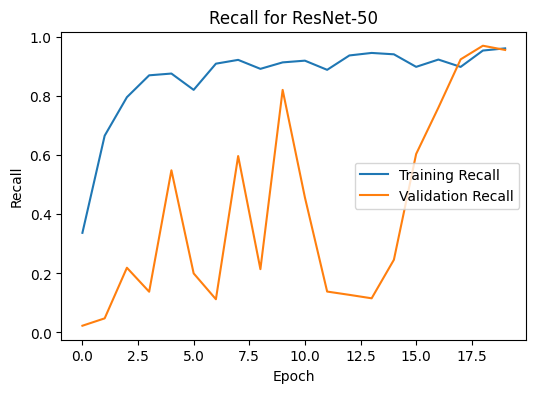

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history_Res.history['recall'], label='Training Recall')
plt.plot(history_Res.history['val_recall'], label='Validation Recall')
plt.title('Recall for ResNet-50')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

#Training DenseNet-121

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

optimizer_dense = Adam(learning_rate=0.001)
loss_dense = 'categorical_crossentropy'


metrics_dense = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall'),
    tf.keras.metrics.F1Score(threshold=0.5, name='f1_score')  # For binary classification
]

In [ ]:
#  DenseNet121 Model
model_Dense.compile(optimizer=optimizer_dense, loss=loss_dense, metrics=metrics_dense,run_eagerly=True)

In [ ]:
# Training DenseNet-121 model
with tf.device('/device:GPU:0'):
  history_Dense = model_Dense.fit(
      train_dataset,
      epochs=10,
      validation_data=val_dataset,
      class_weight=class_weights_dict
  )

Epoch 1/10


236/236 [==============================] - 140s 551ms/step - loss: 0.9541 - accuracy: 0.6239 - precision: 0.8336 - recall: 0.4834 - f1_score: 0.6449 - val_loss: 0.5363 - val_accuracy: 0.8439 - val_precision: 0.9159 - val_recall: 0.7686 - val_f1_score: 0.9032
Epoch 2/10
236/236 [==============================] - 143s 565ms/step - loss: 0.1677 - accuracy: 0.8763 - precision: 0.9144 - recall: 0.8386 - f1_score: 0.9203 - val_loss: 0.2840 - val_accuracy: 0.9172 - val_precision: 0.9339 - val_recall: 0.8928 - val_f1_score: 0.9550
Epoch 3/10
236/236 [==============================] - 144s 564ms/step - loss: 0.0837 - accuracy: 0.9144 - precision: 0.9341 - recall: 0.8974 - f1_score: 0.9535 - val_loss: 0.2464 - val_accuracy: 0.9230 - val_precision: 0.9403 - val_recall: 0.9034 - val_f1_score: 0.9610
Epoch 4/10
236/236 [==============================] - 141s 555ms/step - loss: 0.0637 - accuracy: 0.9299 - precision: 0.9442 - recall: 0.9189 - f1_score: 0.9613 - val_loss: 0.1293 - val_accuracy: 0.9559

loss and accuracy

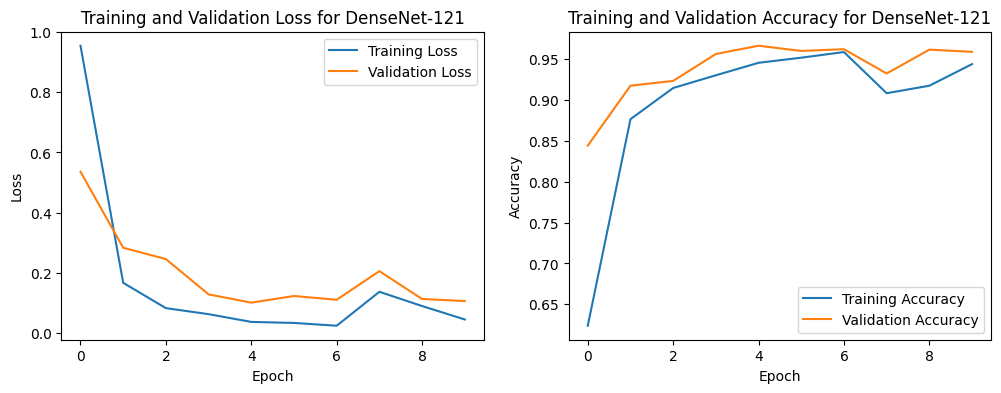

In [ ]:
# Plot Training and Validation Loss and Accuracy for DenseNet-121
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_Dense.history['loss'], label='Training Loss')
plt.plot(history_Dense.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for DenseNet-121')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_Dense.history['accuracy'], label='Training Accuracy')
plt.plot(history_Dense.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for DenseNet-121')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

precision

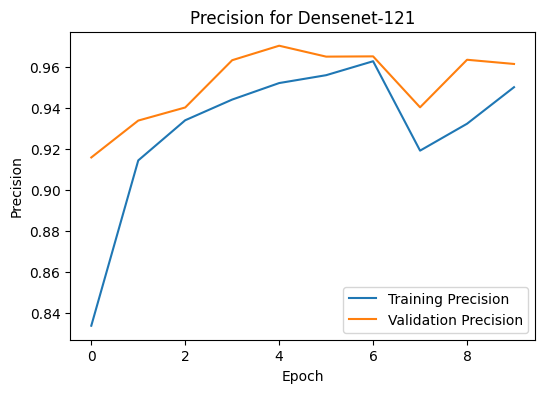

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history_Dense.history['precision'], label='Training Precision')
plt.plot(history_Dense.history['val_precision'], label='Validation Precision')
plt.title('Precision for Densenet-121')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

recall

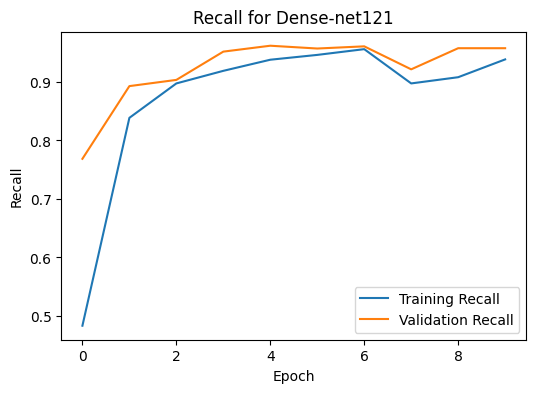

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history_Dense.history['recall'], label='Training Recall')
plt.plot(history_Dense.history['val_recall'], label='Validation Recall')
plt.title('Recall for Dense-net121')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Evaluation and results


ResNet-50


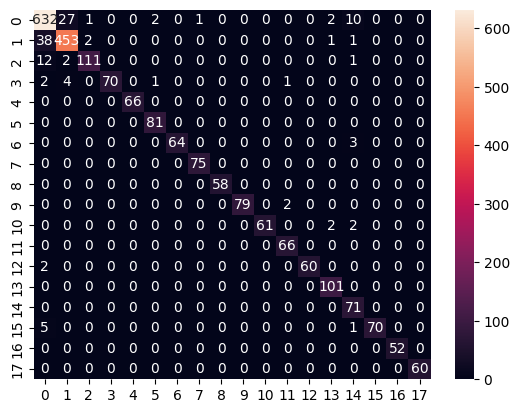

                                 precision    recall  f1-score   support

                         Normal       0.91      0.94      0.93       675
                      Pneumonia       0.93      0.92      0.92       495
                   Tuberculosis       0.97      0.88      0.93       126
                        abscess       1.00      0.90      0.95        78
                           ards       1.00      1.00      1.00        66
                    atelectasis       0.96      1.00      0.98        81
   atherosclerosis_of_the_aorta       1.00      0.96      0.98        67
                   cardiomegaly       0.99      1.00      0.99        75
                      emphysema       1.00      1.00      1.00        58
                       fracture       1.00      0.98      0.99        81
              hydropneumothorax       1.00      0.94      0.97        65
                    hydrothorax       0.96      1.00      0.98        66
                pneumosclerosis       1.00      0.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_dataset, index_to_class):
    y_pred = []
    y_true = []
    for images, labels in test_dataset.unbatch():
        preds = model.predict(tf.expand_dims(images, axis=0), verbose=0)  # Set verbose=0 to suppress output
        y_pred.append(np.argmax(preds, axis=1)[0])
        y_true.append(np.argmax(labels, axis=0))

    # Convert indices back to class names
    y_pred_names = [index_to_class[index] for index in y_pred]
    y_true_names = [index_to_class[index] for index in y_true]

    # Confusion matrix
    cm = confusion_matrix(y_true_names, y_pred_names)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

    # Classification Report
    print(classification_report(y_true_names, y_pred_names))

print("ResNet-50")
evaluate_model(model_Res, test_dataset, index_to_class)


DenseNet-121


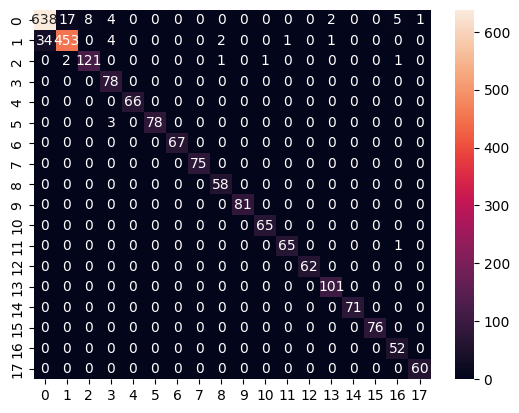

                                 precision    recall  f1-score   support

                         Normal       0.95      0.95      0.95       675
                      Pneumonia       0.96      0.92      0.94       495
                   Tuberculosis       0.94      0.96      0.95       126
                        abscess       0.88      1.00      0.93        78
                           ards       1.00      1.00      1.00        66
                    atelectasis       1.00      0.96      0.98        81
   atherosclerosis_of_the_aorta       1.00      1.00      1.00        67
                   cardiomegaly       1.00      1.00      1.00        75
                      emphysema       0.95      1.00      0.97        58
                       fracture       1.00      1.00      1.00        81
              hydropneumothorax       0.98      1.00      0.99        65
                    hydrothorax       0.98      0.98      0.98        66
                pneumosclerosis       1.00      1.

In [ ]:
print('DenseNet-121')
evaluate_model(model_Dense, test_dataset, index_to_class)